# Import libraries

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Import modules

In [2]:
# Add path for module
# FIXME: shouldn't need this with a package install (`__init__` should suffice?!)
MODEL_DIR = Path().resolve().parent / "PetersenEtAl2011"
sys.path.append(str(MODEL_DIR))

import run_average_displacement

# View the docstrings

In [3]:
help(run_average_displacement)

Help on module run_average_displacement:

NAME
    run_average_displacement

DESCRIPTION
    This file runs the PEA11 principal fault displacement model to calculate the average
    displacement that is implied by the model prediction.
    - Any number of scenarios are allowed (e.g., user can enter multiple magnitudes).
    - The model-implied Average Displacement is calculated as the area under the mean slip profile.
    - The results are returned in a pandas DataFrame.
    - Only the principal fault displacement models for direct (i.e., not normalized) predictions are
    implemented herein currently.
    - Command-line use is supported; try `python run_average_displacement.py --help`
    - Module use is supported; try `from run_average_displacement import run_ad`
    
    # NOTE: This script just calls `run_displacement_profile.py` which in turn calls `run_displacement_model.py`
    
    Reference: https://doi.org/10.1785/0120100035

FUNCTIONS
    main()
    
    run_ad(*, magnitude

# Run Average Displacement

## Single scenarios

A single scenario is defined as a magnitude/style. Here is an example (note all parameters must be passed as keyword arguments).

In [4]:
df = run_average_displacement.run_ad(magnitude=7)
df

magnitude  model_name        style  avg_displ
0        7.0  elliptical  strike-slip   1.183029

The Petersen et al. (2011) model provides three alternative submodels for different profile shapes. The default is the elliptical model, but the user can choose other options, such as `submodel="quadratic"`:

In [5]:
df = run_average_displacement.run_ad(magnitude=7, submodel="quadratic")
df

magnitude model_name        style  avg_displ
0        7.0  quadratic  strike-slip   1.173158

This model should only be used for strike-slip faulting. That is the default style. A `UserWarning` will be issued and the user input will be over-ridden in the output table if another style is entered, such as `style="reverse"`:

In [6]:
df = run_average_displacement.run_ad(magnitude=7, submodel="quadratic", style="reverse")
df

D:\Documents\_mydocs\Work FDHI\TEAM\Journal\kea23\PetersenEtAl2011\run_displacement_model.py:172: UserWarning: This model is only recommended for strike-slip faulting, but 'reverse' was entered.User input will be over-ridden.
  warnings.warn(


magnitude model_name        style  avg_displ
0        7.0  quadratic  strike-slip   1.173158

## Multiple scenarios

Multiple magnitude/submodel scenarios can be run. All combinations of magnitudes and submodels are run. Here is an example.

In [7]:
df = run_average_displacement.run_ad(magnitude=[6.5, 7, 7.5], submodel=["elliptical", "quadratic"])
df

magnitude  model_name        style  avg_displ
0        6.5  elliptical  strike-slip   0.482742
1        6.5   quadratic  strike-slip   0.479481
2        7.0  elliptical  strike-slip   1.183029
3        7.0   quadratic  strike-slip   1.173158
4        7.5  elliptical  strike-slip   2.899180
5        7.5   quadratic  strike-slip   2.870394

## Create magnitude scaling plots

*** #FIXME: There is a problem with how the bilinear model is currently implemented for anything except the median (50th percentile). The standard deviation changes across $l/L$ and Figure 5b in PEA11 cannot be reproduced. 

By default, values that are not the median will be dropped from the results; however, this can be over-ridden for debugging purposes with `debug_bilinear_model=True`. 

We will do this over-ride here because the average displacement is calculated from the mean displacement profile, and we can see in the plot below that the error in the implementation affects the average displacement that is implied from the mean slip profile.

In [8]:
magnitudes = np.arange(5, 8.6, 0.1)
models = ["elliptical", "quadratic", "bilinear"]

results = run_average_displacement.run_ad(
    magnitude=magnitudes,
    submodel=models,
    debug_bilinear_model=True,
)
results.head()

D:\Documents\_mydocs\Work FDHI\TEAM\Journal\kea23\PetersenEtAl2011\run_displacement_model.py:252: UserWarning: #FIXME: Don't use the bilinear model for anything except median 50th percentile; current code does not reproduce Fig 5b in P11.
  warnings.warn(


magnitude  model_name        style  avg_displ
0        5.0    bilinear  strike-slip   0.031562
1        5.0  elliptical  strike-slip   0.032800
2        5.0   quadratic  strike-slip   0.032735
3        5.1    bilinear  strike-slip   0.037705
4        5.1  elliptical  strike-slip   0.039240

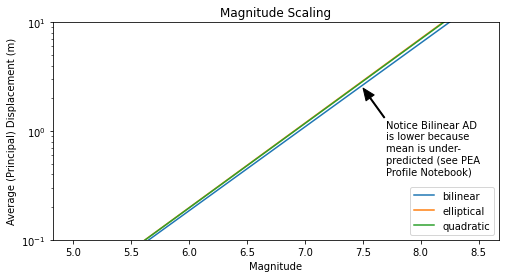

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for model, group in results.groupby(["model_name"]):
    group = group.sort_values(by="magnitude")
    ax.semilogy(group["magnitude"], group["avg_displ"], label=model)

ax.set(
    xlabel="Magnitude",
    ylabel="Average (Principal) Displacement (m)",
    title="Magnitude Scaling",
)
ax.set_ylim([0.1, 10])
ax.legend(loc="lower right")

ax.annotate(
    "Notice Bilinear AD\nis lower because\nmean is under-\npredicted (see PEA\nProfile Notebook)",
    xy=(7.5, 2.5),
    xytext=(7.7, 0.4),
    arrowprops=dict(facecolor="black", width=1, headwidth=10, shrink=0.01),
);